# Explicit & Implicit Finite Difference Modelling

## Finite Difference Example

In [5]:
def Plate2DFD(I):
    '''
    Function Plate2DFD(I)
    Inputs:
    I - number of x, y slices ((I-2)**2 (calculation points or nodes)
    Notes:
    - u[i,j] is solution array - row index defines y coord, column index defines x coord
    - insulated at x=0 (j=0) and x=1 (j=J-1)
    - u(x,0) = 0 (i=0)
    - u(x, 1) = step function from 1 to 0 at x=1/3 - see lecture notes W3W), i=I-1
    Returns - matplotlib plotting objects - colour contour, 3d surface plot
    H. Chesser - October 2016, updated graphics output October 2017
    '''
    #imports
    import numpy as np
    import scipy.sparse as spsp
    import scipy.sparse.linalg as spsplin
    import scipy.interpolate as spint
    import matplotlib.pyplot as plt
    from mpl_toolkits.mplot3d import Axes3D
    J=I
    length=(J-2)*(I-2)
    #Form conductance matrix G (sparse matrix)
    Gdiag = -4.*np.ones(length)
    Gsubs = np.ones(length)
    G = spsp.spdiags([Gsubs, Gsubs, Gdiag, Gsubs, Gsubs], [-(I-2), -1, 0, 1, J-2], length, length)
    G = spsp.csr_matrix(G) #convert to csr (Compressed Sparse Row) in order to adjust some matrix entries
    #top row in a column not connected to bottom row - zero corresponding off-diagonal terms
    for k in range (J-3):
        G[(k+1)*(I-2)-1, (k+1)*(I-2)] = 0.
        G[(k+1)*(I-2), (k+1)*(I-2)-1] = 0.
    # insulated B.C. - adjust diagonal term
    for k in range(J-2):
        G[k,k] = -3.
        G[k+(J-2)*(I-3),k+(J-2)*(I-3)] = -3.
    #Form column matrix b - right hand side of matrix equation
    b = np.zeros(length)
    # Add temp up to x=1/3
    Js = int(np.floor(J/3))
    for i in range(Js-1):
        b[(i+1)*(I-2)-1] = -1.0
        
    #Solve for solution as column vector
    Temp = spsplin.spsolve(G,b)
    #Place column vector entries into 2D array (u) for surface plot and 1D array (Z) for contour plot
    u=np.zeros((I,J))
    Z = np.zeros(I*J)
    for i in range(1,J-1):
        u[1:(I-1),i]= Temp[(I-2)*(i-1):(I-2)*i]
        Z[J*i+1:J*i+I-1] = Temp[(I-2)*(i-1):(I-2)*i]
    # fill outer columns for insulated B.C.
    u[1:(I-1),0] = u[1:(I-1), 1]
    Z[1:(I-1)]=Z[J+1:J+I-1]
    u[1:(I-1),(J-1)] = u[1:(I-1),(J-2)]
    Z[(I-2)*J+1:(I-2)*J+I-1]=Z[(I-1)*J+1:(I-1)*J+I-1]
    #Apply B.C.s at y=0 and y=1
    u[0,:] = 0. # already zero, but just to be sure
    Z[0:(J-1)*I:J] = 0.
    u[I-1,:Js] = 1.0 #remaining columns are already zero
    Z[J-1:(J-1)+Js*J:J] = 1.0
    #Make a contour and surface plot of the result
    fig = plt.figure(figsize=(9,6))
    #ax = fig.add_subplot(1, 2, 1, projection='3d')
    ax = fig.add_subplot(2, 1, 1)
    xi = np.linspace(0., 1., 300)
    yi = np.linspace(0. ,1. ,300)
    Xr = np.linspace(0., 1., I)
    Yc = np.linspace(0., 1., J)
    X = [Xr[int(k/I)] for k in range(I*J)]
    Y = [Yc[k%I] for k in range(I*J)]
    # VERY IMPORTANT, to tell matplotlib how your data is organized
    zi = spint.griddata((X, Y), Z, (xi[None,:], yi[:,None]), method='linear')
    #CS = plt.contour(xi,yi,zi,15,linewidths=0.5,color='k')
    im = plt.imshow(zi, interpolation='bilinear', origin='lower', cmap='jet', extent=(0., 1., 0., 1.))
    levels = np.arange(0., 1., 0.1)
    CS = plt.contour(zi, levels, origin='lower', linewidths=2, extent=(0., 1., 0., 1.))
    CB = plt.colorbar(im, orientation='vertical', shrink=0.8)
    ax.grid()
    ax = fig.add_subplot(2, 1, 2, projection='3d')
    xig, yig = np.meshgrid(Xr, Yc)
    surf = ax.plot_surface(xig, yig, u, linewidth=0, cmap='jet')
    plt.show()
    return

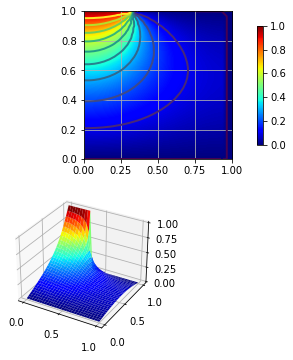

In [7]:
Plate2DFD(30)


### analytical solution


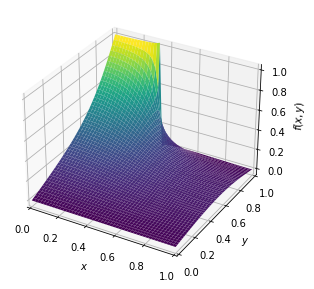

In [8]:
#Analytical solution
import sympy as sym
import mpmath
import sympy.plotting as symplt
Ak, x, y, k, u = sym.symbols('Ak x y k u', real=True)
N = 100
uN = mpmath.nsum(lambda k: 2/(k*sym.pi)*sym.sin(k*sym.pi/3)*
sym.cos(k*sym.pi*x)*sym.sinh(k*sym.pi*y)/sym.sinh(k*sym.pi), [1, N])
symplt.plot3d(uN+y/3, (x, 0., 1.), (y, 0., 1.), xlabel='$x$', ylabel='$y$');

## Explicit Examples

### 1. $u_{t} = u_{xx}$

Boundary Conditions

$u_{x}(0,t)=-1$

$u(2,t)=-10$

Initial Conditions

$u(x,0)=-10$

In [1]:
def explicitFD(L, J, Tf, M, α):
    '''
    Function explicitEx(L, J, Tf, M, α)
    Inputs:
    L - length of x domain
    J - number of x slices (J+1 calculation points or nodes)
    Tf - final solution time
    M - number of time slices
    α - thermal diffusivity of domain (k/(ρ*c))
    Notes - B.C.'s:
    - heat flux at x=0 of Q/A = -1*k, (k = 1 assumed), temp at x=L, held at -10
    - initial condition - all nodes start at -10 deg
    - Explicit finite difference algorithm used - see Tveito, Winther, Chp 4.1 - 4.3
    - user should ensure r = α*Tf*J/(M*L) is less than 0.5 for numerical stability
    - r value printed in plot title
    Returns:
    Matplotlib plot object - plot of temperature array
    H. Chesser - October 2016
    '''
    #imports
    import numpy as np
    import matplotlib.pyplot as plt
    from mpl_toolkits.mplot3d import Axes3D
    
    # Calculate mesh parameter
    dx = L/J
    dt = Tf/M
    r = α*dt/dx**2
    
    #Initialize solution array
    u = np.zeros((M+1,J+1)) #time = row index , x = column index
    
    #Apply initial condition
    u[0,:] = -10. #row 0, all columns
    
    #Apply B.C. at x=l
    u[:,-1] = -10. #all rows, last column

    #Recursion formula - Python for loop
    for m in range(0,M):
        u[m+1,1:J] = [r*u[m,j-1]+(1-2*r)*u[m,j]+r*u[m,j+1] for j in range(1,J)]# Python list comprehension across the row
        u[m+1,0] = u[m+1,1]+dx # B.C. at x=0
    
    #Make a surface plot of the result
    dfplot = plt.figure(figsize=(9,4.5))
    dfplot = plt.subplot(projection='3d')
    x = np.linspace(0., L, J+1)
    t = np.linspace(0., Tf, M+1)
    xv, tv = np.meshgrid(x, t)
    dfplot.plot_surface(xv, tv, u, cmap='jet')
    dfplot.set_xlabel('x')
    dfplot.set_ylabel('t')
    dfplot.set_zlabel(' Temp u(x,t)')
    dfplot.set_title("r = $\\alpha$ $\\frac{\Delta t}{\Delta x^2}$ ="+"{:.4f}".format(r))
    plt.show()

In [2]:
#%precision 4
#%matplotlib ipympl
import matplotlib.pyplot as plt

# Solution code
# to get the Greek letter, type \alpha, then hit Tab
α = 1.

#Discretization parameters
L = 2. # length of thermal path in x direction
J = 20 #slices along the x direction
dx = L/J
Tf = 2. #end time of simulation (start time is 0)
M = 2000 #time slices
dt = Tf/M
r = α*dt/dx**2
r

#For numerical stability r <= 0.5 - See Tveito, Winther, Chp 4.3

0.09999999999999998

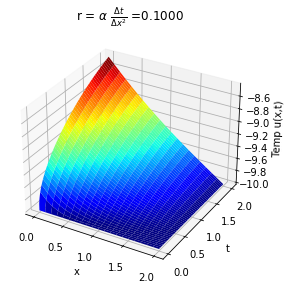

In [3]:
explicitFD(L, J, Tf, M, α)

### 2. $u_{t} = u_{xx}$

Boundary Conditions

$u(0,t)=0$

$u(1,t)=0$

Initial Conditions

$u(x,0)=sin14 \pi x$

In [4]:
def explicitFD(L, J, Tf, M, α):
    '''
    Function explicitEx(L, J, Tf, M, α)
    Inputs:
    L - length of x domain
    J - number of x slices (J+1 calculation points or nodes)
    Tf - final solution time
    M - number of time slices
    α - thermal diffusivity of domain (k/(ρ*c))
    Notes - B.C.'s:
    - heat flux at x=0 of Q/A = -1*k, (k = 1 assumed), temp at x=L, held at -10
    - initial condition - all nodes start at -10 deg
    - Explicit finite difference algorithm used - see Tveito, Winther, Chp 4.1 - 4.3
    - user should ensure r = α*Tf*J/(M*L) is less than 0.5 for numerical stability
    - r value printed in plot title
    Returns:
    Matplotlib plot object - plot of temperature array
    H. Chesser - October 2016
    '''
    #imports
    import numpy as np
    import matplotlib.pyplot as plt
    from mpl_toolkits.mplot3d import Axes3D
    
    # Calculate mesh parameter
    dx = L/J
    dt = Tf/M
    r = α*dt/dx**2
    
    #Initialize solution array
    u = np.zeros((M+1,J+1)) #time = row index , x = column index
        
    #Apply initial condition
    u[0,:] = [np.sin(np.pi*14*dx*i) for i in range (J+1)] #row 0, all columns
    
    #Apply B.C. at x=l
    #u[:,0] = 0. #all rows, first column
    #u[:,-1] = 0. #all rows, last column

    #Recursion formula - Python for loop
    for m in range(0,M):
        u[m+1,1:J] = [r*u[m,j-1]+(1-2*r)*u[m,j]+r*u[m,j+1] for j in range(1,J)]# Python list comprehension across the row
        
    
    #Make a surface plot of the result
    dfplot = plt.figure(figsize=(9,4.5))
    dfplot = plt.subplot(projection='3d')
    x = np.linspace(0., L, J+1)
    t = np.linspace(0., Tf, M+1)
    xv, tv = np.meshgrid(x, t)
    dfplot.plot_surface(xv, tv, u, cmap='jet')
    dfplot.set_xlabel('x')
    dfplot.set_ylabel('t')
    dfplot.set_zlabel(' Temp u(x,t)')
    dfplot.set_title("r = $\\alpha$ $\\frac{\Delta t}{\Delta x^2}$ ="+"{:.4f}".format(r))
    plt.show()

In [5]:
#%precision 4
#%matplotlib ipympl
import matplotlib.pyplot as plt

# Solution code
# to get the Greek letter, type \alpha, then hit Tab
α = 1.

#Discretization parameters
L = 1. # length of thermal path in x direction
J = 400 #slices along the x direction
dx = L/J
Tf = 0.003 #end time of simulation (start time is 0)
M = 2000 #time slices
dt = Tf/M
r = α*dt/dx**2



#For numerical stability r <= 0.5 - See Tveito, Winther, Chp 4.3

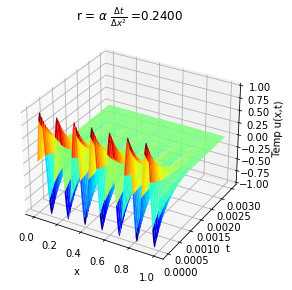

In [6]:
explicitFD(L, J, Tf, M, α)

### 3. $u_{t} = u_{xx}$

Boundary Conditions

$u_{x}(0,t)=0$

$u(1,t)=0$

Initial Conditions

$u(x,0)=x^{3}$

In [36]:
def explicitFD(L, J, Tf, M, α):
    '''
    Function explicitEx(L, J, Tf, M, α)
    Inputs:
    L - length of x domain
    J - number of x slices (J+1 calculation points or nodes)
    Tf - final solution time
    M - number of time slices
    α - thermal diffusivity of domain (k/(ρ*c))
    Notes - B.C.'s:
    - heat flux at x=0 of Q/A = -1*k, (k = 1 assumed), temp at x=L, held at -10
    - initial condition - all nodes start at -10 deg
    - Explicit finite difference algorithm used - see Tveito, Winther, Chp 4.1 - 4.3
    - user should ensure r = α*Tf*J/(M*L) is less than 0.5 for numerical stability
    - r value printed in plot title
    Returns:
    Matplotlib plot object - plot of temperature array
    H. Chesser - October 2016
    '''
    #imports
    import numpy as np
    import matplotlib.pyplot as plt
    from mpl_toolkits.mplot3d import Axes3D
    
    # Calculate mesh parameter
    dx = L/J
    dt = Tf/M
    r = α*dt/dx**2
    
    #Initialize solution array
    u = np.zeros((M+1,J+1)) #time = row index , x = column index
        
    #Apply initial condition
    u[0,:] = [((dx*i)**3) for i in range (J+1)] #row 0, all columns
    
    #Apply B.C. at x=l
    #u[:,0] = 0. #all rows, first column
    #u[:,-1] = 0. #all rows, last column

    #Recursion formula - Python for loop
    for m in range(0,M):
        u[m+1,1:J] = [r*u[m,j-1]+(1-2*r)*u[m,j]+r*u[m,j+1] for j in range(1,J)]# list comprehension across the row
        # need the slope BCs here... CHANGED THIS PART
        u[m+1, 0] = u[m+1,1]
        u[m+1, -1] = u[m+1, -2]
        
    
    #Make a surface plot of the result
    dfplot = plt.figure(figsize=(9,4.5))
    dfplot = plt.subplot(projection='3d')
    x = np.linspace(0., L, J+1)
    t = np.linspace(0., Tf, M+1)
    xv, tv = np.meshgrid(x, t)
    dfplot.plot_surface(xv, tv, u, cmap='jet')
    dfplot.set_xlabel('x')
    dfplot.set_ylabel('t')
    dfplot.set_zlabel(' Temp u(x,t)')
    dfplot.set_title("r = $\\alpha$ $\\frac{\Delta t}{\Delta x^2}$ ="+"{:.4f}".format(r))
    plt.show()

In [17]:
#%precision 4
#%matplotlib ipympl
import matplotlib.pyplot as plt

# Solution code
# to get the Greek letter, type \alpha, then hit Tab
α = 1.

#Discretization parameters
L = 1. # length of thermal path in x direction
J = 20 #slices along the x direction
dx = L/J
Tf = .2 #end time of simulation (start time is 0)
M = 2000 #time slices
dt = Tf/M
r = α*dt/dx**2


#For numerical stability r <= 0.5 - See Tveito, Winther, Chp 4.3

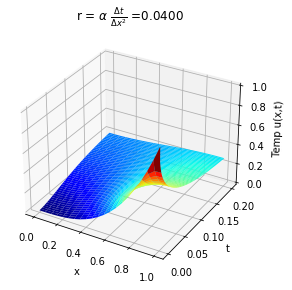

In [18]:
explicitFD(L, J, Tf, M, α)

### 4. $u_{t} = u_{xx}$

Boundary Conditions

$u_{x}(0,t)=u_{x}$

$u(1,t)=0$

Initial Conditions

$u(x,0)=x^{3}$

In [37]:
def explicitFD(L, J, Tf, M, alpha):
    '''
    Function explicitEx(L, J, Tf, M, alpha)
    Inputs:
    L - length of x domain
    J - number of x slices (J+1 calculation points or nodes)
    Tf - final solution time
    M - number of time slices
    alpha - thermal diffusivity of domain (k/(rho*c))
    Notes - B.C.'s:
    - at x=0 and x= L, 0 heat flow
    - initial condition - x**3
    - Explicit finite difference algorithm used - see Tveito, Winther, Chp 4.1 - 4.3
    - user should ensure r = alpha*Tf*J/(M*L) is less than 0.5 for numerical stability
    - r value printed in plot title
    Returns - matplotlib plot object
    H. Chesser - October 2018
    '''
    #imports
    import numpy as np
    import matplotlib.pyplot as plt
    from mpl_toolkits.mplot3d import Axes3D
    # Calculate mesh parameter
    dx = L/J
    dt = Tf/M
    r = α*dt/dx**2
    #Initialize solution array
    u = np.zeros((M+1,J+1)) #time = row index , x = column index
    #Apply initial condition
    u[0,:] = [(dx*j)**3 for j in range(J+1)] #row 0, all columns
    #Apply B.C. at x=L, x=0
    #u[:,J] = 0. #last column, all rows
    #u[:,0] = 0. #first column, all rows
    #Recursion formula - Python for loop

    for m in range(0,M):
        u[m+1,1:J] = [r*u[m,j-1]+(1-2*r)*u[m,j]+r*u[m,j+1] for j in range(1,J)]
        u[m+1,0]= u[m+1, 1] #fill in the formula here BC at x=0
        u[m+1,J]= u[m+1, J-1] #fill in the formula here BC at x=L
    #Make a surface plot of the result
    #Make a surface plot of the result
    dfplot = plt.figure(figsize=(9,4.5))
    dfplot = plt.subplot(projection='3d')
    
    x = np.linspace(0., L, J+1)
    t = np.linspace(0., Tf, M+1)
    xv, tv = np.meshgrid(x, t)
    
    dfplot.plot_surface(xv, tv, u, cmap='jet')
    dfplot.set_xlabel('x')
    dfplot.set_ylabel('t')
    dfplot.set_zlabel(' Temp u(x,t)')
    dfplot.set_title("r = $\\alpha$ $\\frac{\Delta t}{\Delta x^2}$ ="+"{:.4f}".format(r))
    plt.show()

In [38]:
# Solution code
alpha = 1.
#Discretization parameters
L = 1. # length of thermal path in x direction
J = 20 #slices along the x direction
dx = L/J
Tf = 0.4 #time of simulation
M = 400 #time slices
dt = Tf/M
r = alpha*dt/dx**2
r
#For explicit FD numerical stability r <= 0.5 - See Tveito, Winther, Chp 4.3


0.3999999999999999

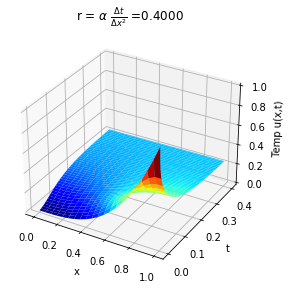

In [39]:
explicitFD(L, J, Tf, M, alpha)

In [ ]:
k_Cu = 390 #W/mK thermal conductivity
k_FR4 = 0.23 #W/mK thermal conmductivity
t_sig = 0.035 #mm thickness of 10z copper
t_pow = 2*t_sig
f_sig = 0.3 #coverage factor for sig layers
f_pow = 0.8 #coverage factor for pow layers
t = 1.5 #mm total thickness of pcb

k_sig = k_Cu *f_sig*t_sig #equivalent total conductivity sig layer
print('conductivity of sig layer: ',k_sig) 

k_pow = k_Cu*f_pow*t_pow #equivalent total conductivity pow layer
print('conductivity of pow layer: ',k_pow)

k_FR4 = k_FR4*(t-2*t_sig-2*t_pow) #equivalent total conductivity fr-4 layer
print('conductivity of fr4 layer: ', k_FR4)

k_eff = (2*k_sig+2*k_pow+k_FR4)/t
k_eff, 'W/m-K'

conductivity of sig layer:  4.095000000000001
conductivity of pow layer:  21.840000000000003
conductivity of fr4 layer:  0.2967


(34.777800000000006, 'W/m-K')

### 1D Heat Equation with Dirichlet Boundary Conditions and a Source Term in the Interior of the Domain (Explicit)
### 1. $u_{xx} = -f(x)$

Boundary Conditions

$u(0)=0$

$u(1)=0$

for 0<x<0.4: 
$f(x)=0$

for 0.4<x<0.6:
$f(x)=1$

for 0.6<x<1:
$f(x)=0$


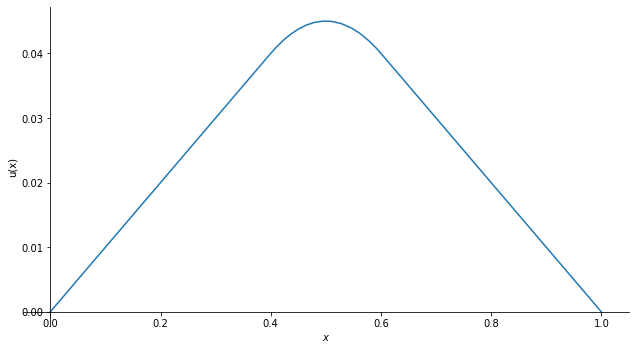

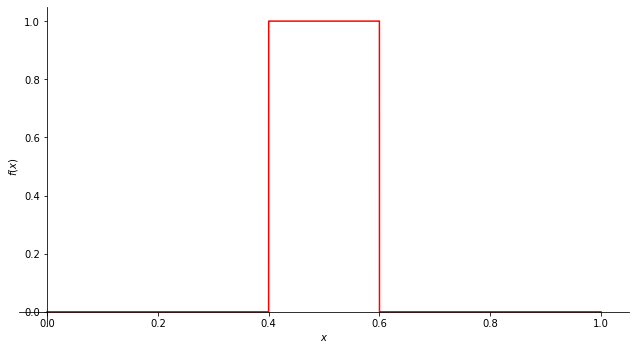

In [43]:
import sympy.plotting as symplt
import matplotlib.pyplot as plt
import sympy as sym
sym.init_printing()
plt.rcParams['figure.figsize'] = 9,5
x = sym.Symbol('x', real=True, positive=True)
ux = sym.Piecewise((0.1*x, x<0.4), (0.1*x-0.5*(x-0.4)**2, sym.And(x>=0.4,x<0.6)),(0.1-0.1*x, True))
fx = sym.Piecewise((0, x<0.4), (1, sym.And(x>=0.4,x<0.6)),(0, True)) 
symplt.plot(ux, (x, 0., 1.), ylabel='u(x)') 
symplt.plot(fx, (x, 0., 1.), line_color='red')

## Implicit Examples

### 1. $u_{t} = u_{xx}$

Boundary Conditions

$u_{x}(0,t)=-1$

$u(2,t)=-10$

Initial Conditions

$u(x,0)=-10$

In [19]:
def implicitFD(L, J, Tf, M, α):
    '''
    Function implicitEx(L, J, Tf, M, α)
    Inputs:
    L - length of x domain
    J - number of x slices (J+1 calculation points or nodes)
    Tf - final solution time
    M - number of time slices
    α - thermal diffusivity of domain (k/(rho*c))
    Notes - B.C.'s:
    - heat flux at x=0 of Q = -1*k, (k = 1 assumed)
    - fixed temp at x=L of -10 deg
    - initial condition - all nodes start at -10 deg
    - Implicit finite difference algorithm used - see Tveito, Winther, Chp 4.4 - 4.5
    - r = α*Tf*J**2/(M*L) - for implicit algorithm unconditionally stable
    - r value printed in plot title for comparison with explicit output
    Returns:
    Matplotlib plot object - 3d surface of u(x,t) solution
    H. Chesser - October 2016
    '''
    #imports
    import numpy as np
    import scipy.sparse as spsp
    import scipy.sparse.linalg as spsplin
    import matplotlib.pyplot as plt
    from mpl_toolkits.mplot3d import Axes3D
    
    # Calculate mesh parameter
    dx = L/J
    dt = Tf/M
    r = α*dt/dx**2
    
    #Initialize solution array
    u = np.zeros((M+1,J+1)) #time = row index , x = column index
    
    #Apply initial condition
    u[0,:] = -10. #row 0, all columns
    
    #Apply B.C. at x=L
    u[:,-1] = -10. #last column, all rows
    
    #Set up matrix [I + rA] - Scipy Sparse matrices
    Adiag = (1.+2.*r)*np.ones(J)
    Asubs = -r*np.ones(J)
    Asuper = -r*np.ones(J)
    I_rA = spsp.spdiags([Asubs, Adiag, Asuper], [-1, 0, 1], J, J)
    I_rA = spsp.csr_matrix(I_rA)
    
    #adjust matrix for x=0 BC
    I_rA[0,0] = 1.
    I_rA[0,1] = -1.
    
    #adjust RHS for x=L BC
    b = np.zeros(J)
    b[J-1] = r*(-10)
    for m in range(0,M):
        c = u[m,:J] + b
        c[0] = dx # x=0 RHS
        u[m+1,:J] = spsplin.spsolve(I_rA, c)
        
    #Make a surface plot of the result
    dfplot = plt.figure(figsize=(9,4.5))
    dfplot = plt.subplot(projection='3d')
    
    x = np.linspace(0., L, J+1)
    t = np.linspace(0., Tf, M+1)
    xv, tv = np.meshgrid(x, t)
    
    dfplot.plot_surface(xv, tv, u, cmap='winter')
    dfplot.set_xlabel('x')
    dfplot.set_ylabel('t')
    dfplot.set_zlabel(' Temp u(x,t)')
    dfplot.set_title("r = $\\alpha$ $\\frac{\Delta t}{\Delta x^2}$ ="+"{:.4f}".format(r))
    plt.show()

In [14]:
#%precision 4
#%matplotlib ipympl
# Solution code
α = 1.
#Discretization parameters
L = 2. # length of thermal path in x direction
J = 40 #slices along the x direction
dx = L/J
Tf = 2. #time of simulation
M = 2000 #time slices
dt = Tf/M
r = α*dt/dx**2
r

0.3999999999999999

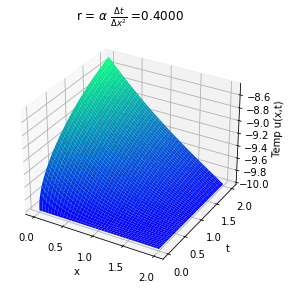

In [15]:
implicitFD(L, J, Tf, M, α)

### 2. $u_{t} = u_{xx}$

Boundary Conditions

$u(0,t)=0$

$u(1,t)=0$

Initial Conditions

$u(x,0)=sin14 \pi x$

In [4]:
def implicitFD(L, J, Tf, M, α):
    '''
    Function implicitEx(L, J, Tf, M, α)
    Inputs:
    L - length of x domain
    J - number of x slices (J+1 calculation points or nodes)
    Tf - final solution time
    M - number of time slices
    α - thermal diffusivity of domain (k/(rho*c))
    Notes - B.C.'s:
    - heat flux at x=0 of Q = -1*k, (k = 1 assumed)
    - fixed temp at x=L of -10 deg
    - initial condition - all nodes start at -10 deg
    - Implicit finite difference algorithm used - see Tveito, Winther, Chp 4.4 - 4.5
    - r = α*Tf*J**2/(M*L) - for implicit algorithm unconditionally stable
    - r value printed in plot title for comparison with explicit output
    Returns:
    Matplotlib plot object - 3d surface of u(x,t) solution
    H. Chesser - October 2016
    '''
    #imports
    import numpy as np
    import scipy.sparse as spsp
    import scipy.sparse.linalg as spsplin
    import matplotlib.pyplot as plt
    from mpl_toolkits.mplot3d import Axes3D
    
    # Calculate mesh parameter
    dx = L/J
    dt = Tf/M
    r = α*dt/dx**2
    
    #Initialize solution array
    u = np.zeros((M+1,J+1)) #time = row index , x = column index
    
    #Apply initial condition
    u[0,:] = [np.sin(np.pi*14*dx*i) for i in range (J+1)] #row 0, all columns
    
    #Apply B.C. at x=L
    u[:,-1] = 0. #last column, all rows
    u[:,0] = 0 #first column, all rows
    
    #Set up matrix [I + rA] - Scipy Sparse matrices
    Adiag = (1.+2.*r)*np.ones(J)
    Asubs = -r*np.ones(J)
    Asuper = -r*np.ones(J)
    I_rA = spsp.spdiags([Asubs, Adiag, Asuper], [-1, 0, 1], J, J)
    I_rA = spsp.csr_matrix(I_rA)
    
    #adjust matrix for x=0 BC
    #I_rA[0,0] = 1.
    #I_rA[0,1] = -1.
    
    #adjust RHS for x=L BC
    #b = np.zeros(J)
    #b[J-1] = r*(-10)
    for m in range(0,M):
        c = u[m,:J]
        #c[0] = dx # x=0 RHS
        u[m+1,:J] = spsplin.spsolve(I_rA, c)
        
    #Make a surface plot of the result
    dfplot = plt.figure(figsize=(9,4.5))
    dfplot = plt.subplot(projection='3d')
    
    x = np.linspace(0., L, J+1)
    t = np.linspace(0., Tf, M+1)
    xv, tv = np.meshgrid(x, t)
    
    dfplot.plot_surface(xv, tv, u, cmap='winter')
    dfplot.set_xlabel('x')
    dfplot.set_ylabel('t')
    dfplot.set_zlabel(' Temp u(x,t)')
    dfplot.set_title("r = $\\alpha$ $\\frac{\Delta t}{\Delta x^2}$ ="+"{:.4f}".format(r))
    plt.show()

In [5]:
#%precision 4
#%matplotlib ipympl

# Solution code
α = 1.

#Discretization parameters
L = 1. # length of thermal path in x direction
J = 400 #slices along the x direction
dx = L/J
Tf = 0.0025 #end time of simulation (start time is 0)
M = 2000 #time slices
dt = Tf/M
r = α*dt/dx**2


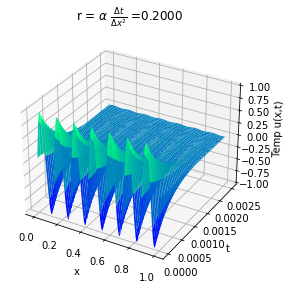

In [6]:
implicitFD(L, J, Tf, M, α)

### 3. $u_{t} = u_{xx}$

Boundary Conditions

$u_{x}(0,t)=0$

$u(1,t)=0$

Initial Conditions

$u(x,0)=x^{3}$

In [25]:
def implicitFD(L, J, Tf, M, α):
    '''
    Function implicitEx(L, J, Tf, M, α)
    Inputs:
    L - length of x domain
    J - number of x slices (J+1 calculation points or nodes)
    Tf - final solution time
    M - number of time slices
    α - thermal diffusivity of domain (k/(rho*c))
    Notes - B.C.'s:
    - heat flux at x=0 of Q = -1*k, (k = 1 assumed)
    - fixed temp at x=L of -10 deg
    - initial condition - all nodes start at -10 deg
    - Implicit finite difference algorithm used - see Tveito, Winther, Chp 4.4 - 4.5
    - r = α*Tf*J**2/(M*L) - for implicit algorithm unconditionally stable
    - r value printed in plot title for comparison with explicit output
    Returns:
    Matplotlib plot object - 3d surface of u(x,t) solution
    H. Chesser - October 2016
    '''
    #imports
    import numpy as np
    import scipy.sparse as spsp
    import scipy.sparse.linalg as spsplin
    import matplotlib.pyplot as plt
    from mpl_toolkits.mplot3d import Axes3D
    
    # Calculate mesh parameter
    dx = L/J
    dt = Tf/M
    r = α*dt/dx**2
    
    #Initialize solution array
    u = np.zeros((M+1,J+1)) #time = row index , x = column index
    
    #Apply initial condition
    u[0,:] = [((dx*i)**3) for i in range (J+1)] #row 0, all columns
    
    #Apply B.C. at x=L
    # Charlie: first of these rows is included for the x=L BC
    #u[1:,-1] = 0. #last column, all rows - it's already zero, but just in case
    #u[:,0] = 0 #first column, all rows
    
    #Set up matrix [I + rA] - Scipy Sparse matrices
    Adiag = (1.+2.*r)*np.ones(J-1)
    Asubs = -r*np.ones(J-1)
    Asuper = -r*np.ones(J-1)
    I_rA = spsp.spdiags([Asubs, Adiag, Asuper], [-1, 0, 1], J-1, J-1)
    I_rA = spsp.csr_matrix(I_rA)
    
    #adjust matrix for x=0 BC
    # Charlie - these lines are included for the slope conditions
    I_rA[0,0] = 1.+r
    I_rA[-1,-1] = 1.+r
    
    # loop through the time steps
    for m in range(0,M):
        c = u[m,1:J]
        # we have zero slope this time, so no change in temp at x=0, x=l
        u[m+1,1:J] = spsplin.spsolve(I_rA, c)
        u[m+1,0] = u[m+1, 1]
        u[m+1, -1] = u[m+1, -2]
        
    #Make a surface plot of the result
    dfplot = plt.figure(figsize=(9,4.5))
    dfplot = plt.subplot(projection='3d')
    
    x = np.linspace(0., L, J+1)
    t = np.linspace(0., Tf, M+1)
    xv, tv = np.meshgrid(x, t)
    
    dfplot.plot_surface(xv, tv, u, cmap='jet')
    dfplot.set_xlabel('x')
    dfplot.set_ylabel('t')
    dfplot.set_zlabel(' Temp u(x,t)')
    dfplot.set_title("r = $\\alpha$ $\\frac{\Delta t}{\Delta x^2}$ ="+"{:.4f}".format(r))
    plt.show()

In [26]:
#%precision 4
#%matplotlib ipympl

# Solution code
α = 1.

#Discretization parameters
L = 1. # length of thermal path in x direction
J = 20 #slices along the x direction
dx = L/J
Tf = .4 #end time of simulation (start time is 0)
M = 2000 #time slices
dt = Tf/M
r = α*dt/dx**2
r

0.07999999999999999

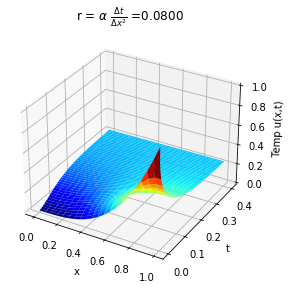

In [27]:
implicitFD(L, J, Tf, M, α)

## PCB Example

A CubeSat PCB has an 8 layer design. The layers can be grouped as follows:

$6$ signal layers with (20 percent copper coverage)

$2$ power/ground layers (80 percent copper coverage)

remaining thickness FR4 glass epoxy

All copper layers are 1 oz Copper thickness

What is the effective thermal conductivity of this board?
For copper k = 390 W/mk , for fr-4 k = 0.23

In [32]:
k_Cu = 390 #W/mK thermal conductivity
k_FR4 = 0.23 #W/mK thermal conmductivity
t_sig = 0.035 #mm thickness of 10z copper
t_pow = 2*t_sig
f_sig = 0.3 #coverage factor for sig layers
f_pow = 0.8 #coverage factor for pow layers
t = 1.5 #mm total thickness of pcb

k_sig = k_Cu *f_sig*t_sig #equivalent total conductivity sig layer
print('conductivity of sig layer: ',k_sig) 

k_pow = k_Cu*f_pow*t_pow #equivalent total conductivity pow layer
print('conductivity of pow layer: ',k_pow)

k_FR4 = k_FR4*(t-2*t_sig-2*t_pow) #equivalent total conductivity fr-4 layer
print('conductivity of fr4 layer: ', k_FR4)

k_eff = (2*k_sig+2*k_pow+k_FR4)/t
k_eff, 'W/m-K'

conductivity of sig layer:  4.095000000000001
conductivity of pow layer:  21.840000000000003
conductivity of fr4 layer:  0.2967


(34.777800000000006, 'W/m-K')

## 2D polar Coordinate


### 1. Heat transfer through a cylinder with fixed wall temperature


Ti = 0
To = 1
ri = 0.5
ro = 2

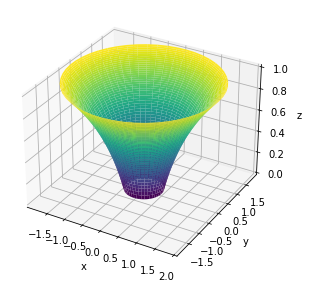

In [2]:
#%matplotlib ipympl
import sympy.plotting as symplt
import matplotlib.pyplot as plt
import sympy as sym
sym.init_printing()
plt.rcParams['figure.figsize'] = 9,5
r, theta, x, y, T_o, T_i, r_o, r_i = sym.symbols('r theta x y T_o T_i r_o r_i', real=True)
u = T_i+(T_o-T_i)*sym.ln(r/r_i)/sym.ln(r_o/r_i)
T = u.subs([(T_i, 0), (T_o, 1.), (r_i, 0.5), (r_o, 2.0)]) #<-------------------------------- Specify the boundary conditions here
symplt.plot3d_parametric_surface(r*sym.cos(theta), r*sym.sin(theta), T, (r, 0.5, 2.), (theta, 0., 2*sym.pi));

### 2. polar Coordinate

Change above example in two ways:

Conduct a heat quantity of 1W/m^2

assume k = 1




Ti = 0
To = 1
ri = 0.5
ro = 2

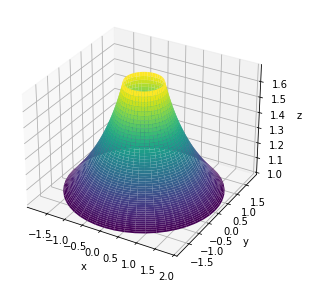

In [40]:
import matplotlib.pyplot as plt
import sympy.plotting as symplt
import sympy as sym
sym.init_printing()
r, θ, x, y, T_o, T_i, r_o, r_i, k = sym.symbols('r θ x y T_o T_i r_o r_i k', real=True)
u1 = r_i*sym.ln(r_o/r) + T_o
T1 = u1.subs([(T_o, 1.), (r_i, 0.5), (r_o, 2.0)])#<-------------------------------- Specify the boundary conditions here
symplt.plot3d_parametric_surface(r*sym.cos(θ), r*sym.sin(θ), T1, (r, 0.5, 2.), (θ, 0., 2*sym.pi));

### 3. polar Coordinate

Change above example in two ways:

remove center hole outer temp changes with angle:

$u(ro,0 <theta <pi)=To$

$u(ro,pi <theta <2pi)=0$

In [17]:
# Check with sympy
import mpmath
r, θ, r_o, T_o = sym.symbols('r θ r_o T_o', real=True)
k = sym.symbols('k', integer=True, positive=True)
f = sym.Piecewise((T_o, θ <sym.pi), (0, True))
A_0 = 1/(2*sym.pi)*sym.integrate(f, (θ, 0, 2*sym.pi))
A_0

In [18]:
k = sym.symbols('k', integer=True, positive=True)
A_k = 1/(r_o**k*sym.pi)*sym.integrate(f*sym.cos(k*θ), (θ, 0, 2*sym.pi))
A_k

In [19]:
B_k = sym.simplify(1/(r_o**k*sym.pi)*sym.integrate(f*sym.sin(k*θ), (θ, 0, 2*sym.pi)))
B_k

In [20]:
k_e = sym.symbols('k_e', integer=True, even=True)
k_o = sym.symbols('k', integer=True, odd=True)
B_ke = B_k.subs(k, k_e)
B_ko = B_k.subs(k, k_o)
B_ke, B_ko

Input the T_o and R_o here and the code will calculate the temperature distribution

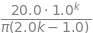

In [29]:
B_ks = sym.simplify(B_ko.subs([(T_o, 10.), (r_o, 1.), (k_o, 2*k-1)]))
B_ks

input the values from the function above

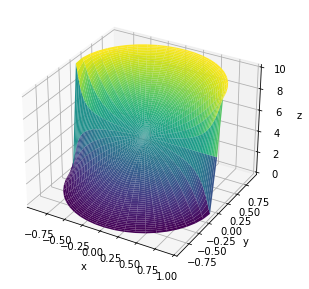

In [28]:
N = 100
#u2 = A_0.subs(T_o, 10)+mpmath.nsum(lambda k: 10/(k*sym.pi)*(1-sym.cos(k*sym.pi))*sym.sin(k*θ)*(r)**k, [1,N])
u2 = A_0.subs(T_o, 10.)+mpmath.nsum(lambda k: 20./((2*k-1)*sym.pi)*sym.sin((2*k-1)*θ)*r**(2*k-1), [1, N])
symplt.plot3d_parametric_surface(r*sym.cos(θ), r*sym.sin(θ), u2, (r, 0., 1.), (θ, 0., 2*sym.pi));

# Radiation

## Potential Questions:

### 1. What is the Stefan-Boltzmann Law?

- The Stefan-Boltzmann Law states that the power radiated by a black body is proportional to the fourth power of the absolute temperature of the body. The proportionality constant is called the Stefan-Boltzmann constant, and has the value 5.670373 × 10−8 W m−2 K−4.

    $e(T)=\sigma T^{4}$

### 2. What is Planck's Law? How is it related to the Stefan-Boltzmann Law?

- Planck's Law states that the power radiated by a black body is proportional to the frequency of the radiation. The proportionality constant is called the Planck's constant, and has the value 6.62607004 × 10−34 J s.

    $e(\lambda)=\frac{hc}{\lambda^{5}}\frac{1}{e^{\frac{hc}{\lambda kT}}-1}$
 
    $e_{\lambda}(\lambda, T)=\left(\frac{2 \pi h c}{\lambda^{5}}\right)\left(\frac{1}{e^{\frac{n c}{\lambda k T}-1}}\right)$

### 3. Important wavebands to consider in thermal radiation

- Solar radiation: 0.2e-6 to 2.0e-6 m

- Thermal: 5e-6 to 35e-6 m

### 4. Hot vs Cold objects

- the ratio of absorbed to emitted radiation is called the emissivity of the object. The emissivity of a black body is 1.0. The emissivity of a perfect mirror is 0.0. The emissivity of a perfect gray body is 0.5.
- a hot object will have a high absorptivity and a low emissivity. A cold object will have a low absorptivity and a high emissivity.

### 5. What is the difference between the monochromatic emittance and total emittance of a surface?

- The monochromatic emittance is the emittance of a surface at a particular wavelength.

    $\epsilon_{\lambda}=\frac{e_{\lambda}(\lambda, T)}{e_{\lambda, b}(\lambda, T)}$


- The total emittance is the emittance of a surface over the entire spectrum of radiation.

    $\epsilon=\frac{e(T)}{e{b}(T)}=\frac{\int_{0}^{\infty} e{\lambda}(\lambda, T) d \lambda}{\sigma T^{4}}=\frac{\int_{0}^{\infty} e{\lambda} e_{\lambda, b}(\lambda, T) d \lambda}{\sigma T^{4}}$

### 6. What is Kirchoff's Law?

- Kirchoff's law states that a body in thermodynamic equilibrium with its environment emits as much energy as it absorbs in each direction and at each wavelength

    $\epsilon_{\lambda}(T)=\alpha_{\lambda}(T)$

    $\epsilon_{\lambda} =$ spectral emittance
    
    $\alpha_{\lambda} =$ spectral absorptance

### 7. Why does the solar constant $S = 1366~W/m^2$ vary and by how much?

- The main variation in the solar constant is due to the Earth's elliptical orbit around the sun. A second source of variation is due to the 11 year solar cycle. The flux varies from 1321.6 $W/m^2$ (aphelion) and 1412.9 $W/m^2$ (perihelion).

### 8. What is the equivalent blackbody temperature of a planet?

- The equivalent blackbody temperature of a planet, $T_P$ is the temperature of a blackbody necessary to balance the solar energy received. $$S_p \pi R_P^2 \left( 1-a \right) = 4 \pi R_P^2 \sigma T_P^4$$ where $a$, $R_P$ are the albedo coefficient and the radius of the planet and $S_p$ is the solar flux at the radius of the planet's orbit.

### 9. 3 types of Environmental Fluxes to consider for Spacecraft heating

1.  Direct Solar

    $\Large{q_{Sun} = \frac{Q_{Sun}}{A} = S F_{i-S} = S \cos{\theta}}$
    $\Large{q_{Sun}^a = \alpha q_{Sun}}$

    - where $\theta$ is the angle between the surface normal (flat surface) and the sun vector and $\alpha$ is the solar absorptivity of the surface in question. For a curved surface we use the projected area. $F_{i-S}$, $\alpha$ are the solar viewfactor and solar absorptivity of the surface in question.
    
2. Albedo

    $\Large{q_{Alb} = a S F_{i-lP} = S aF(altitude, \phi)} $
    $\Large{q_{Alb}^a = \alpha q_{Alb}}$

    - where $a$ is the planet albedo factor (0.35 typical for Earth), $F$ is an "albedo visibility factor", $\phi$ is the solar zenith angle - angle between Sun-Planet vector and Planet-Spacecraft vector - see below. $F_{i-lP}$, $\alpha$ are the planet viewfactor (illuminated portion) and solar absorptivity of the surface in question.

3. Earth IR

    $\Large{q_E = E F_{i-P} = \sigma T_P^4 F_{i-P}}$
    $\Large{q_E^a = \epsilon q_E}$

    - where $E$ is the Earth IR flux (236.4 $W/m^2$), $T_P$ is the corresponding planet equivalent blackbody temperature and $F_{i-P}$, $\epsilon$ are the planet viewfactor and IR emissivity of the surface in question.

### 10. For a particular body ("body1") radiating to a set of other surfaces from an enclosure, what is the sum of the viewfactors from body1 to the enclosure surfaces? Why?

- The sum of the viewfactors from body1 to the enclosure surfaces is 1.0. This is because the viewfactor is the ratio of the area of the body1 surface that is visible to the area of the enclosure surface. The sum of the viewfactors from body1 to the enclosure surfaces is the total area of the enclosure surface that is visible to body1.

- Because the surfaces that body 1 sees fully enclosure it, the sum of the viewfactors from 1 to these surfaces (including itself) must sum to 1. This is because light emitted from body 1 must strike one of the enclosure surfaces or itself.

### 11. What is viewfactor? what is viewfactor reciprocity?

- The viewfactor is the ratio of the area of the body1 surface that is visible to the area of the enclosure surface. This is used to calculate the amount of energy exchanged between our spacecraft and a radiating surface. The viewfactor reciprocity is the viewfactor from body1 to body2 is equal to the viewfactor from body2 to body1.

    $A_1 F_{1-2}=A_2 F_{2-1}$

### 12. 3 cases for spacecraft handcalculating viewfactors

H = altitude of spacecraft above surface
h = Distance from center of earth to spacecraft
r = radius of earth



1. Nadir Face

    $H=\frac{h}{r}$

    $F_{1 \cdot 2}=\left(\frac{1}{H}\right)^{2}$

2. Side Face

    $H=\frac{h}{r}$

    $F_{1-2}=\frac{1}{\pi}\left[\tan ^{-1}\left(\frac{1}{\sqrt{H^2 -1}}\right)-\frac{\sqrt{H^{2}-1}}{H^{2}}\right]$

3. Sphere to Sphere

    $r{2}>>r{1}$

    $H=\frac{r{1}+S+r{2}}{r_{2}}$

    $F_{1-2}=\frac{1}{2}\left(1-\sqrt{1-\frac{1}{H^{2}}}\right)$

4. spacecraft to space environment

    $F_{1-2}= \epsilon$

- H is the altitude of the spacecraft above the surface
- h is the distance from the center of the earth to the spacecraft
- r is the radius of the earth
- $\epsilon$ is the emissivity of the spacecraft
- S is the distance between center of spheres

### 13. What is the Radiosity of a surface?

- The radiosity of a surface is the total emitted and reflected energy per unit area

    $B=$ radiosity

    $H=$ irradiance or incomming flux

    $\rho=$ reflectivity

    $\epsilon=$ emissivity
    
    $e_{b}=$ blackbody emittance

    $B=\rho H+\epsilon e_{b}$





## Example - Plasma Instrument

- A cylindrical plasma probe orbits at 1600 km.
- Its outer walls are rhodium plated and its outboard end is painted black
- The inboard end faces the spacecraft and can be assumed insulated.
- What is the temperature, neglecting earth and albedo inputs?

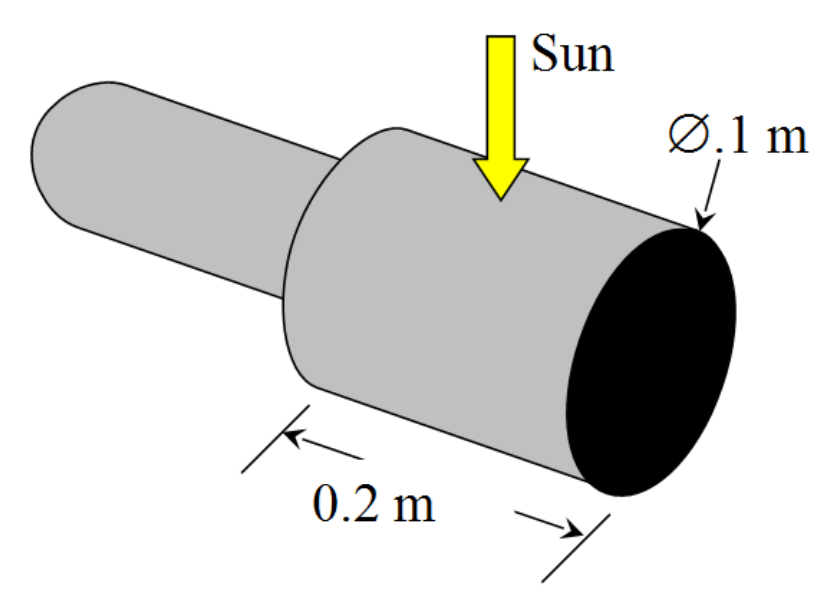

In [53]:
from IPython.display import Image
Image(filename='C:/Users/Aiden/Desktop/Schoolwork/ESSE3360/plasma_instrument.png') 

In [5]:
# Surface properties - given in the problem
#Rhodium plate
#Note to use Greek letters, type \alpha, then hit Tab
α_rh_s = 0.35
ϵ_rh_ir = 0.06
#Black Paint
α_b_s = 0.95
ϵ_b_ir = 0.95
#Conductive Paint
α_c_s = 0.3
ϵ_c_ir = 0.3
#5 mil AgFEP second surface mirror
α_ss_s = 0.09
ϵ_ss_IR = 0.75

In [6]:
#Q_in = Q_out - steady solution-------------Rhodium plate everywhere--------------
# Assume the cylinder and end cap at one temperature
import numpy as np
import scipy.constants as const
degC = "\u00b0C"
# constants
σ = const.sigma #W/m**2/K**4 (5.67e-8)
S = 1366 #W/m**2 - mean solar flux
#Areas
Ap_cyl = 0.1*0.2 #m**2 - projected area of cylinder
A_cyl = np.pi*0.1*0.2 #m**2 - total surface area of cylinder
A_cap = np.pi/4*0.1**2 #m**2 - end cap area
#Rhodium plated cylinder and on end cap
Q_in_rh = α_rh_s * S * Ap_cyl
print("Q_in_rh = ", Q_in_rh, "W")
RIF_out_rh = ϵ_rh_ir * σ * A_cyl + ϵ_rh_ir * σ * A_cap
print("RIF_out_rh = ", RIF_out_rh, "W/K**4")
T_rh = np.sqrt(np.sqrt(Q_in_rh / RIF_out_rh)) - 273.15
print("T_rh = %.2f%s" % (T_rh, degC))

Q_in_rh =  9.562000000000001 W
RIF_out_rh =  2.4048908934075757e-10 W/K**4
T_rh = 173.39°C



### - same calculation but change to Rhodium plating on cylinder and black paint on end cap

In [46]:
#Now use black paint on the end cap, Rhodium plate on the cylinder
RIF_out_rhb = ϵ_rh_ir * σ * A_cyl
+ ϵ_b_ir * σ * A_cap
# Note same Q_in as for the Rhodium case
T_rhb = np.sqrt(np.sqrt(Q_in_rh / RIF_out_rhb)) - 273.15
print("T_rhb = %.2f%s" % (T_rhb, degC))

T_rhb = 186.74°C


### - same calculations, but change to Conductive paint on cylinder, black paint on the end cap

In [47]:
#Now use conductive paint on the cylinder, black paint on the end cap
Q_in_c = α_c_s * S * Ap_cyl
RIF_out_cb = ϵ_c_ir * σ * A_cyl
+ ϵ_b_ir * σ * A_cap
T_cb = np.sqrt(np.sqrt(Q_in_c / RIF_out_cb)) - 273.15
print("T_cb = %.2f%s" % (T_cb, degC))

T_cb = 22.77°C


### - same calculations, but change to 5mil AgFEP on the cylinder, black paint on end cap 

In [48]:
#Now use 5mil AgFEP on the cylinder, black paint on end cap
Q_in_ss = α_ss_s * S * Ap_cyl
RIF_out_ss = ϵ_ss_IR * σ * A_cyl
+ ϵ_b_ir * σ * A_cap
T_ss = np.sqrt(np.sqrt(Q_in_ss / RIF_out_ss)) - 273.15
print("T_ss = %.2f%s" % (T_ss, degC))


T_ss = -98.98°C


## On your Own - Orbit Flux Example
A 1-m cube spacecraft ($\alpha = 0.35,~\epsilon = 0.06$ orbits in a dawn-dusk sunsynchronous orbit in locked rotation at 600 km. Calculate the orbital heat loads for this orbit
manually and using SST, compare you results. Post your comparison for at least one of the surfaces to the Student Questions forum.

In [6]:
# im assuming that the sun is shining on one side of the cube at all times throughout the orbit
import scipy.constants as const
σ = const.sigma #W/m**2/K**4 (5.67e-8)
S = 1366 #W/m**2 - mean solar flux
degC = "\u00b0C"
# Surface properties - given in the problem
#Rhodium plate
#Note to use Greek letters, type \alpha, then hit Tab
α_rh_s = 0.35
ϵ_rh_ir = 0.06
#Black Paint
α_b_s = 0.95
ϵ_b_ir = 0.95
#Conductive Paint
α_c_s = 0.3
ϵ_c_ir = 0.3
#5 mil AgFEP second surface mirror
α_ss_s = 0.09
ϵ_ss_IR = 0.75
A_side = 1.0 #m**2 - are of one side of the box
A_cube = 6 #m**2 - total surface area of cube
Q_in_rh_cube = α_rh_s * S * A_side
print("Q_in_rh_cube = ", Q_in_rh_cube, "W")
RIF_out_rh_cube = ϵ_rh_ir * σ * A_cube
print("RIF_out_rh_cube = ", RIF_out_rh_cube, "W/K**4")
T_rh_cube = np.sqrt(np.sqrt(Q_in_rh_cube / RIF_out_rh_cube)) - 273.15
print("T_rh_cube = %.2f%s" % (T_rh_cube, degC))

Q_in_rh_cube =  478.09999999999997 W
RIF_out_rh_cube =  2.04133479084e-08 W/K**4
T_rh_cube = 118.05°C


### Nadir facing viewfactor calculation( code for Q12 Nadir)

$H=\frac{h}{r}$

$F_{1 \cdot 2}=\left(\frac{1}{H}\right)^{2}$


In [1]:
#Check
ϵ_ir = 0.8
E = 235.4 #W/m**2
H=(600+6378)/6378
F_1e=H**-2
qe = ϵ_ir*E*F_1e
F_1e, qe

(0.8354242925869215, 157.32710277996907)

### Side facing viewfactor calculation( code for Q12 Side)

$H=\frac{h}{r}$

$F_{1-2}=\frac{1}{\pi}\left[\tan ^{-1}\left(\frac{1}{\sqrt{H^2 -1}}\right)-\frac{\sqrt{H^{2}-1}}{H^{2}}\right]$

In [3]:
import numpy as np
F_1e_side = 1/np.pi*(np.arctan(1/np.sqrt(H**2-1))-np.sqrt(H**2-1)/H**2)
qe_side = 0.8*236.4*F_1e_side
#Check
F_1e_side, qe_side

(0.24900657398711523, 47.09212327244323)

## Calculating true orbital fluxes

F_12_nadir = 0.8354, F_12_side = 0.2490


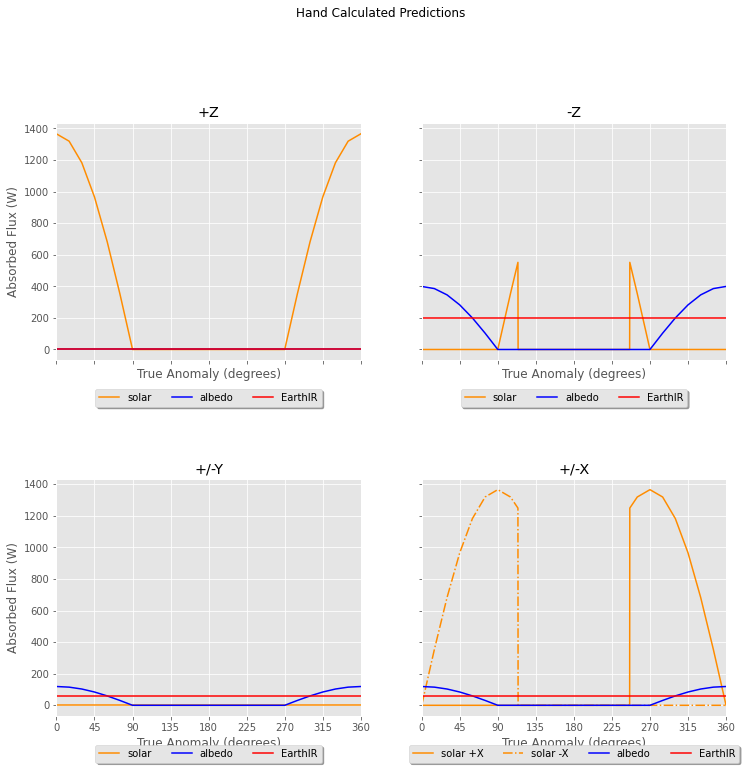

In [29]:
# Parameter set-up
import numpy as np

#Orbit parameter (circular orbit)
h = 600 #km
β = 0 #degrees

#Black surface properties
ϵ = 1.
α = 1.
A = 1.

# Planet characteristics
Re = 6378 #km
μ = 398600.5 #km^3/s^2

eclipse_s = np.degrees(np.pi/2 + np.arccos(Re/(Re+h)))
eclipse_e = np.degrees(3*np.pi/2 - np.arccos(Re/(Re+h)))

eclipse_s, eclipse_e
(117.31, 242.69)
#Thermal environment parameters

S = 1366 #W/m^2 - Average value
a = 0.35 # Average value from Fortescue, et al
E = 236.4 #W/m^2

def viewfactors(h):
    
    import numpy as np
    Re = 6378. #km

    H = (h+Re)/Re

    F_12_nadir = H**-2
    F_12_side = 1/np.pi*(np.arctan(1/np.sqrt(H**2-1))-np.sqrt(H**2-1)/H**2)
    
    msg = 'F_12_nadir = {0:.4f}, F_12_side = {1:.4f}'.format(F_12_nadir, F_12_side)
    
    return msg, F_12_nadir, F_12_side
    
msg, VFn, VFs = viewfactors(h)
print(msg)
#F_12_nadir = 0.7895
#F_12_side = 0.2185
#θ array (type '\theta' and then press tab)
#Add points just before and just after eclipse start and stop
#Gives sharp eclipse entry/exit points
θ = np.sort(np.append(np.linspace(0, 360, 25), [eclipse_s-0.1, eclipse_s+0.1, eclipse_e-0.1, eclipse_e+0.1]))


#+Z surface
#solar
PZ_s = S*α*A*np.piecewise(θ, [np.cos(np.radians(θ)) < 0, np.cos(np.radians(θ)) >= 0], 
                                [lambda θ : 0.0, lambda θ: np.cos(np.radians(θ))])
#albedo
PZ_a = np.zeros(len(θ))
#earth IR
PZ_e = np.zeros(len(θ))

#-Z surface
# solar
conds = [np.logical_or(θ >=270., θ < 90.), np.logical_and(θ >= 90, θ < eclipse_s), 
         np.logical_and(θ >= eclipse_s, θ < eclipse_e), np.logical_and(θ >= eclipse_e, θ < 270) ]
funcs = [lambda θ: 0., lambda θ: -np.cos(np.radians(θ)), lambda θ: 0., lambda θ: -np.cos(np.radians(θ))]
MZ_s = S*α*A*np.piecewise(θ, conds, funcs)
#albedo
MZ_a = α*a*S*A*VFn*np.piecewise(θ, [np.cos(np.radians(θ)) < 0, np.cos(np.radians(θ)) >= 0], 
                                       [lambda θ : 0.0, lambda θ: np.cos(np.radians(θ))])
#Earth IR
MZ_e = E*ϵ*A*VFn*np.ones(len(θ))

#+/-Y surfaces
#solar
PY_s = np.zeros(len(θ))
MY_s = np.zeros(len(θ))
#albedo
PY_a = α*a*S*A*VFs*np.piecewise(θ, [np.cos(np.radians(θ)) < 0, np.cos(np.radians(θ)) >= 0], 
                                       [lambda θ : 0.0, lambda θ: np.cos(np.radians(θ))])
MY_a = PY_a
#Earth IR
PY_e = E*ϵ*A*VFs*np.ones(len(θ))
MY_e = PY_e

#+/-X
# solar
conds = [np.logical_and(θ >=0., θ < eclipse_s), np.logical_and(θ >= eclipse_s, θ < eclipse_e), 
         np.logical_and(θ >= eclipse_e, θ <= 360.)]
PX_funcs = [lambda θ: 0., lambda θ: 0., lambda θ: -np.sin(np.radians(θ))]
MX_funcs = [lambda θ: np.sin(np.radians(θ)), lambda θ: 0., lambda θ: 0.]
PX_s = S*α*A*np.piecewise(θ, conds, PX_funcs)
MX_s = S*α*A*np.piecewise(θ, conds, MX_funcs)
#albedo
PX_a = α*a*S*A*VFs*np.piecewise(θ, [np.cos(np.radians(θ)) < 0, np.cos(np.radians(θ)) >= 0], 
                                       [lambda θ : 0.0, lambda θ: np.cos(np.radians(θ))])
MX_a = PX_a
#Earth IR
PX_e = E*ϵ*A*VFs*np.ones(len(θ))
MX_e = PX_e

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.style.use('ggplot')
%matplotlib inline
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12.0,12.0), sharey=True, sharex=True)
plt.suptitle('Hand Calculated Predictions')
ax1.plot(θ,PZ_s, label='solar', color='darkorange')
ax1.plot(θ, PZ_a, label='albedo', color='blue')
ax1.plot(θ, PZ_e, label='EarthIR', color='red')
ax1.set_title('+Z')

ax2.plot(θ,MZ_s, label='solar', color='darkorange')
ax2.plot(θ, MZ_a, label='albedo', color='blue')
ax2.plot(θ, MZ_e, label='EarthIR', color='red')
ax2.set_title('-Z')

ax3.plot(θ,PY_s, label='solar', color='darkorange')
ax3.plot(θ, PY_a, label='albedo', color='blue')
ax3.plot(θ, PY_e, label='EarthIR', color='red')
ax3.set_title('+/-Y')

ax4.plot(θ,PX_s, label='solar +X', color='darkorange')
ax4.plot(θ,MX_s, label='solar -X', color='darkorange', linestyle='-.')
ax4.plot(θ, PX_a, label='albedo', color='blue')
ax4.plot(θ, PX_e, label='EarthIR', color='red')
ax4.set_title('+/-X')


plt.setp((ax1, ax2, ax3, ax4), xticks=np.arange(0., 361., 45.))
ax1.set_ylabel('Absorbed Flux (W)')
ax3.set_ylabel('Absorbed Flux (W)')
for ax in ax1, ax2, ax3, ax4:
    ax.grid(True)
    ax.set_xlim(0., 360.)
    ax.set_xlabel('True Anomaly (degrees)')
    ax.legend()
    # Shrink current axis's height by 10% on the bottom
    box = ax.get_position()
    ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.8])

    # Put a legend below current axis
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
          fancybox=True, shadow=True, ncol=5)

plt.show()


In [30]:
# PZ_s is the solar flux on the +Z surface
# PZ_a is the albedo flux on the +Z surface
# PZ_e is the Earth IR flux on the +Z surface
# MZ_s is the solar flux on the -Z surface
# MZ_a is the albedo flux on the -Z surface
# MZ_e is the Earth IR flux on the -Z surface
# PY_s is the solar flux on the +Y surface
# PY_a is the albedo flux on the +Y surface
# PY_e is the Earth IR flux on the +Y surface
# MY_s is the solar flux on the -Y surface
# MY_a is the albedo flux on the -Y surface
# MY_e is the Earth IR flux on the -Y surface
# PX_s is the solar flux on the +X surface
# PX_a is the albedo flux on the +X surface
# PX_e is the Earth IR flux on the +X surface
# MX_s is the solar flux on the -X surface
# MX_a is the albedo flux on the -X surface
# MX_e is the Earth IR flux on the -X surface

# Here I am calculating the average total flux on each surface over the course of the orbit  
PZ_total_avg = sum(PZ_s + PZ_a + PZ_e)/len(PZ_s)
MZ_total_avg = sum(MZ_s + MZ_a + MZ_e)/len(MZ_s)
PY_total_avg = sum(PY_s + PY_a + PY_e)/len(PY_s)
MY_total_avg = sum(MY_s + MY_a + MY_e)/len(MY_s)
PX_total_avg = sum(PX_s + PX_a + PX_e)/len(PX_s)
MX_total_avg = sum(MX_s + MX_a + MX_e)/len(MX_s)

print('PZ_total_avg = ', PZ_total_avg)
print('MZ_total_avg = ', MZ_total_avg)
print('PY_total_avg = ', PY_total_avg)
print('MY_total_avg = ', MY_total_avg)
print('PX_total_avg = ', PX_total_avg)
print('MX_total_avg = ', MX_total_avg)



PZ_total_avg =  404.8896592407777
MZ_total_avg =  378.3334186968795
PY_total_avg =  94.15221950217892
MY_total_avg =  94.15221950217892
PX_total_avg =  385.1820527958266
MX_total_avg =  385.1820527958264


In [31]:
A_side = 1.0 #m**2 - are of one side of the box
A_cube = 6 #m**2 - total surface area of cube
Q_in_rh_cube1 = α_rh_s * PZ_total_avg * A_side
Q_in_rh_cube2 = α_rh_s * MZ_total_avg * A_side
Q_in_rh_cube3 = α_rh_s * PY_total_avg * A_side
Q_in_rh_cube4 = α_rh_s * MY_total_avg * A_side
Q_in_rh_cube5 = α_rh_s * PX_total_avg * A_side
Q_in_rh_cube6 = α_rh_s * MX_total_avg * A_side
Q_in_rh_cube_total = (Q_in_rh_cube1 + Q_in_rh_cube2 + Q_in_rh_cube3 + Q_in_rh_cube4 + Q_in_rh_cube5 + Q_in_rh_cube6)
print("Q_in_rh_cube = ", Q_in_rh_cube_total, "W")
RIF_out_rh_cube = ϵ_rh_ir * σ * A_cube
print("RIF_out_rh_cube = ", RIF_out_rh_cube, "W/K**4")
T_rh_cube = np.sqrt(np.sqrt(Q_in_rh_cube_total / RIF_out_rh_cube)) - 273.15
print("T_rh_cube = %.2f%s" % (T_rh_cube, degC))

Q_in_rh_cube =  609.6620678867837 W
RIF_out_rh_cube =  2.04133479084e-08 W/K**4
T_rh_cube = 142.56°C
